<a href="https://colab.research.google.com/github/amedyukhina/biomassters/blob/main/biomassters_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Benchmark

Adapted from https://github.com/fnands/BioMassters_baseline/blob/main/unet_baseline.ipynb

In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
numpy==1.21.6
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
rasterio==1.2.0
boto3==1.26.16
pytorch_lightning
segmentation_models_pytorch

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 1.7 MB/s 
     |████████████████████████████████| 19.1 MB 3.0 MB/s 
     |████████████████████████████████| 132 kB 23.9 MB/s 
     |████████████████████████████████| 798 kB 54.9 MB/s 
     |████████████████████████████████| 97 kB 2.6 MB/s 
     |████████████████████████████████| 79 kB 2.9 MB/s 
     |████████████████████████████████| 10.1 MB 54.9 MB/s 
     |████████████████████████████████| 140 kB 13.5 MB/s 
     |████████████████████████████████| 529 kB 53.1 MB/s 
     |████████████████████████████████| 125 kB 70.1 MB/s 
     |████████████████████████████████| 87 kB 7.5 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 376 kB 48.2 MB/s 
     |████████████████████████████████| 127 kB 66.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl siz

In [52]:
from google.colab import drive
import os
import rasterio
import pandas as pd
from tqdm import tqdm
import numpy as np

import boto3
from botocore import UNSIGNED
from botocore.config import Config

from cachetools import cached, TTLCache

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, Normalize
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import os
from torchvision.io import read_image
import rasterio
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
import warnings
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import shutil
# import wandb

# Our rasters contain no geolocation info, so silence this warning from rasterio
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Prepare list of chip IDs

In [31]:
feature_path = 'gdrive/MyDrive/biomassters/info/features_metadata.csv'
train_img_dir = 'train_features'
test_img_dir = 'test_features'
label_dir = 'train_agbm'
output_dir = 'predicted'

In [6]:
df = pd.read_csv(feature_path)

In [7]:
df_pred = df[df['split'] == 'test'].reset_index(drop=True)
pred_ids = np.unique(df_pred['chip_id'])
len(df_pred), len(pred_ids)

(63348, 2773)

In [8]:
df = df[df['split'] == 'train'].reset_index(drop=True)
all_ids = np.unique(df['chip_id'])
len(df), len(all_ids)

(189078, 8689)

In [9]:
np.random.seed(42)
np.random.shuffle(all_ids)

In [10]:
train_ids = all_ids[:500]
val_ids = all_ids[500:550]

### Set up data loading

In [11]:
BUCKET_NAME = 'drivendata-competition-biomassters-public-us'
os.environ["AWS_NO_SIGN_REQUEST"] = 'YES'
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [12]:
cache = TTLCache(maxsize=1000, ttl=86400)

In [13]:
@cached(cache)
def get_image(fn):
  obj = s3.get_object(Bucket=BUCKET_NAME, Key=fn)
  with rasterio.open(obj['Body']) as src:
    img = src.read()
  return img

### Calculate mean and std of the dataset

In [14]:
imgs = np.array([get_image(os.path.join(train_img_dir, 
                                        rf"{chip_id}_S2_10.tif"))[:10].astype(np.float32)
for chip_id in tqdm(train_ids)])

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
imgs.shape

(500, 10, 256, 256)

In [16]:
MEANS = np.array([imgs[:,i].mean() for i in range(imgs.shape[1])])
STDS = np.array([imgs[j,i].std() for j in range(imgs.shape[0]) 
  for i in range(imgs.shape[1])]).reshape((imgs.shape[:2])).mean(0)
MEANS, STDS

(array([ 380.4021 ,  535.0182 ,  421.57675,  817.7593 , 1889.2316 ,
        2205.7764 , 2321.24   , 2394.7937 , 1272.0664 ,  702.64954],
       dtype=float32),
 array([319.6245 , 349.22687, 364.47675, 454.4305 , 777.2495 , 899.8386 ,
        970.10986, 952.7745 , 607.3759 , 443.7978 ], dtype=float32))

### Define a dataset

In [17]:
class SentinelDataset2(Dataset):
    def __init__(self, chip_ids, img_dir, label_dir=None, 
                 transform=None, target_transform=None):
        self.chip_ids = chip_ids
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        image = get_image(os.path.join(self.img_dir, 
                                       rf"{self.chip_ids[idx]}_S2_10.tif"))
        image = torch.tensor(image.astype(np.float32)[:10])
        image = (image - 
                 torch.tensor(MEANS).unsqueeze(1).unsqueeze(1))/torch.tensor(STDS).unsqueeze(1).unsqueeze(1)
        
        if self.label_dir is not None:
            label = get_image(os.path.join(self.label_dir, 
                                           rf"{self.chip_ids[idx]}_agbm.tif"))
            label = torch.tensor(label.astype(np.float32))
        else:
            label = None

        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [18]:
train_ds = SentinelDataset2(train_ids, train_img_dir, label_dir)
val_ds = SentinelDataset2(val_ids, train_img_dir, label_dir)
train_dataloader = DataLoader(train_ds, batch_size=32, 
                              shuffle=True, num_workers = 2)
valid_dataloader = DataLoader(val_ds, batch_size=32, 
                              shuffle=False, num_workers = 2)

test_ds = SentinelDataset2(pred_ids, test_img_dir)
test_dataloader = DataLoader(test_ds, batch_size=32, 
                             shuffle=True, num_workers = 2)

In [19]:
torch.random.manual_seed(42)

In [20]:
imgs, labels = next(iter(train_dataloader))

In [21]:
imgs.shape, labels.shape

(torch.Size([32, 10, 256, 256]), torch.Size([32, 1, 256, 256]))

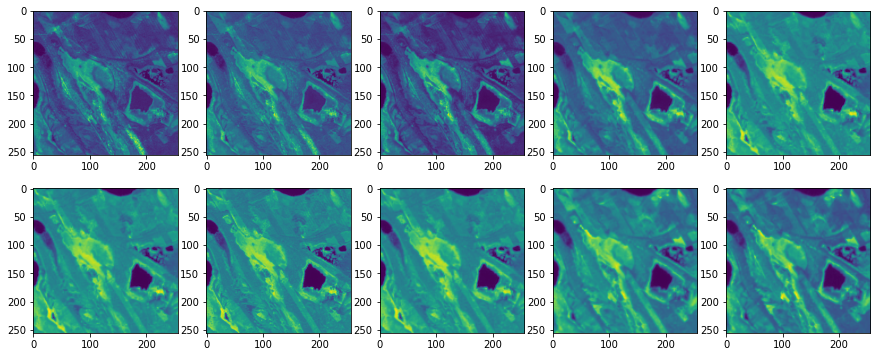

In [22]:
cols = 5
rows = 2
s = 3
fig, axes = plt.subplots(rows, cols, figsize=(s*cols, s*rows))
for img, ax in zip(imgs[0], axes.ravel()):
    ax.imshow(img.numpy())

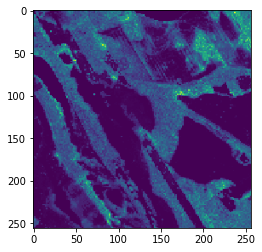

In [23]:
# Show ground truth
plt.imshow(labels[0][0].numpy())

### Define the model and the training pipeline

In [48]:
class Sentinel2Model(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train/loss", loss)
        self.log("train/rmse", torch.sqrt(loss))
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("valid/loss", loss)
        self.log("valid/rmse", torch.sqrt(loss))
        print("valid/rmse", torch.sqrt(loss))
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    def forward(self, x):
        return self.model(x)

In [43]:
base_model = smp.Unet(
    encoder_name="resnet50",       
    in_channels=10,                 
    classes=1,                     
)

In [44]:
!wget https://zenodo.org/record/5610000/files/resnet50-sentinel2.pt

--2022-11-30 05:05:52--  https://zenodo.org/record/5610000/files/resnet50-sentinel2.pt
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94566017 (90M) [application/octet-stream]
Saving to: ‘resnet50-sentinel2.pt.1’

resnet50-sentinel2. 100%[===================>]  90.18M  9.35MB/s    in 73s     

2022-11-30 05:07:06 (1.23 MB/s) - ‘resnet50-sentinel2.pt.1’ saved [94566017/94566017]



In [49]:
base_model.encoder.load_state_dict(torch.load("resnet50-sentinel2.pt"))
s2_model = Sentinel2Model(base_model)

In [50]:
# Initialize a trainer
trainer = Trainer(
    accelerator="gpu",
    max_epochs=20,
)

### Train

In [51]:
%%time
# Train the model ⚡
trainer.fit(s2_model, train_dataloaders=train_dataloader, 
            val_dataloaders=valid_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

valid/rmse tensor(85.6171, device='cuda:0')
valid/rmse tensor(88.0867, device='cuda:0')


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

valid/rmse tensor(1522930.5000, device='cuda:0')
valid/rmse tensor(875929.4375, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(105.5804, device='cuda:0')
valid/rmse tensor(77.5149, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(61.7585, device='cuda:0')
valid/rmse tensor(71.9837, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(55.1178, device='cuda:0')
valid/rmse tensor(64.2062, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(56.8967, device='cuda:0')
valid/rmse tensor(63.3629, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(54.3786, device='cuda:0')
valid/rmse tensor(65.5191, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(51.8290, device='cuda:0')
valid/rmse tensor(61.9797, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(55.3933, device='cuda:0')
valid/rmse tensor(68.2263, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(53.8749, device='cuda:0')
valid/rmse tensor(62.5146, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(54.2876, device='cuda:0')
valid/rmse tensor(63.2068, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(52.5550, device='cuda:0')
valid/rmse tensor(64.0169, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(54.6959, device='cuda:0')
valid/rmse tensor(67.3544, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(53.8454, device='cuda:0')
valid/rmse tensor(62.2168, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(50.6496, device='cuda:0')
valid/rmse tensor(62.0287, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(49.9763, device='cuda:0')
valid/rmse tensor(62.5776, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(54.2875, device='cuda:0')
valid/rmse tensor(65.0423, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(49.6276, device='cuda:0')
valid/rmse tensor(60.2067, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(49.6728, device='cuda:0')
valid/rmse tensor(61.8418, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(57.7958, device='cuda:0')
valid/rmse tensor(61.3595, device='cuda:0')


Validation: 0it [00:00, ?it/s]

valid/rmse tensor(49.2164, device='cuda:0')
valid/rmse tensor(61.6964, device='cuda:0')


### Show example predictions

In [58]:
imgs, labels = next(iter(train_dataloader))
pred = s2_model(imgs.cuda())

In [66]:
def normalize(img):
    p = np.percentile(img, 99)
    img = img - img.min()
    img = img / p
    return np.clip(img, 0, 1)

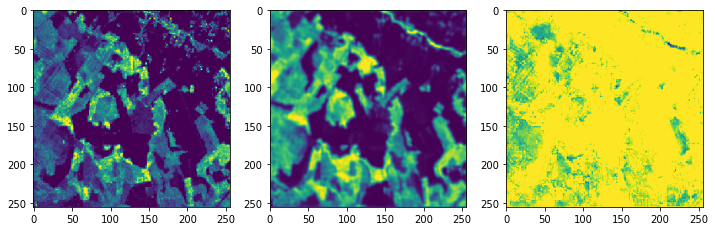

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(normalize(labels[0].numpy()[0]))
axes[1].imshow(normalize(pred[0].cpu().detach().numpy()[0]))
axes[2].imshow(normalize(labels[0].numpy()[0] - pred[0].cpu().detach().numpy()[0]))

### Prediction

In [55]:
os.makedirs(output_dir, exist_ok=True)
s2_model.cuda();
for chip_id in tqdm(pred_ids):
    image = get_image(os.path.join(test_img_dir, 
                                   rf"{chip_id}_S2_10.tif"))
    image = torch.tensor(image.astype(np.float32)[:10])
    image = (image - 
              torch.tensor(MEANS).unsqueeze(1).unsqueeze(1))/torch.tensor(STDS).unsqueeze(1).unsqueeze(1)

    pred = s2_model(image.unsqueeze(0).cuda())
    im = Image.fromarray(pred.squeeze().cpu().detach().numpy())
    im.save(f"{output_dir}/{chip_id}_agbm.tif", format="TIFF", save_all=True)

  0%|          | 0/2773 [00:00<?, ?it/s]

In [56]:
shutil.make_archive('submission', 'zip', output_dir)

'/content/submission.zip'

In [57]:
from google.colab import files
files.download('submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>